In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from pathlib import Path 
import traceback
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt

from hyperbolicTSNE import Datasets
from hyperbolicTSNE import Datasets, SequentialOptimizer, initialization, HyperbolicTSNE
from hyperbolicTSNE.cost_functions_ import HyperbolicKL, GaussianKL
from hyperbolicTSNE.util import find_last_embedding, opt_config, initialize_logger, write_data, store_visuals
from hyperbolicTSNE.data_loaders import load_mnist
from hyperbolicTSNE.hd_mat_ import hd_matrix
from hyperbolicTSNE.visualization import animate, plot_poincare

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.


# Dataset generation code
Generate a specific set of samples we want to use.
Right now we want 10 samples of data with labels 2 and 4.

In [4]:
# MNIST DATA 

# n_samples = 20             # How much to sample from each class
# dataX, dataLabels = load_mnist(data_home=data_home)
# print(dataX.shape, dataLabels.shape)

# indices_2 = np.where(dataLabels == 2)
# indices_4 = np.where(dataLabels == 4)

# samples_idx_2 = np.random.choice(indices_2[0], size=n_samples, replace=False)
# samples_idx_4 = np.random.choice(indices_4[0], size=n_samples, replace=False)

# print(samples_idx_2)
# print(samples_idx_4)

# print(dataLabels[samples_idx_2])
# print(dataLabels[samples_idx_4])

# labels_2 = dataLabels[samples_idx_2]
# labels_4 = dataLabels[samples_idx_4]
# sample_labels = np.concatenate((labels_2, labels_4), axis=0)

# samples_2 = dataX[samples_idx_2]        # samples of number 2
# samples_4 = dataX[samples_idx_4]        # samples of number 4
# sample_data = np.concatenate((samples_2, samples_4), axis=0)    # Contains both 2 and 4 

# print(sample_data.shape)    

In [5]:
from scipy.stats import multivariate_normal

def generate_linear_hierarchical_data(n_samples, n_clusters, n_dim, start, end):
    """ 
    Generate a "hierarchical" dataset where we basically generate clusters from "left" to "right" 
    """
    # n_samples must be a integer multiple of n_clusters
    points_per_cluster = n_samples
    cluster_distances = np.abs(end - start) / n_clusters                            # distance between each cluster
    cluster_centers = [start + i * cluster_distances for i in range(n_clusters)]    # centers of each cluster

    # Generate data
    data = []
    for center in cluster_centers:
        cluster_center = np.ones(n_dim) * center
        cov = (cluster_distances / 3) 
        # cov = 1
        cluster_cov = np.identity(n_dim) * cov
        #cluster_cov = np.identity(n_dim)
        cluster_data = multivariate_normal.rvs(mean=cluster_center, cov=cluster_cov, size=points_per_cluster)
        data.append(cluster_data)

    # Generate labels
    labels = []
    for i in range(n_clusters):
        labels = labels + [i for _ in range(points_per_cluster)]

    return np.array(data), np.array(labels)


# Custom data, Uniform distrib.
from scipy.stats import uniform 
def generate_uniform_clusters(n_samples, n_dim, b1, b2):
    # n_samples = 500
    # n_dim = 10
    # b1 = 1000000
    # b2 = 100

    # Bounds for first distribution
    lb_1 = np.ones(n_dim) * (-b1)
    ub_1 = np.ones(n_dim) * (-b2)
    widths_1 = ub_1 - lb_1 

    # Bounds for 2nd distribution
    lb_2 = np.ones(n_dim) * b2
    ub_2 = np.ones(n_dim) * b1
    widths_2 = ub_2 - lb_2

    # Draw samples 
    samples_1 = uniform.rvs(loc=lb_1, scale=widths_1, size=(n_samples, n_dim))
    samples_2 = uniform.rvs(loc=lb_2, scale=widths_2, size=(n_samples, n_dim))

    dataX = np.concatenate((samples_1, samples_2), axis=0)
    labels = [0 for _ in range(n_samples)] + [1 for _ in range(n_samples)]
    dataLabels = np.array(labels)

    return dataX, dataLabels

# Preperation for running embedding
Get the distance matrix and affinity matrix of our samples
Generate custom dataset (see below)

In [6]:
n_samples = 5
n_clusters = 2
n_dim = 2
start = -100
end = 100

# Generate data
dataX, dataLabels = generate_linear_hierarchical_data(n_samples, n_clusters, n_dim, start, end)
dataX = dataX.reshape((dataX.shape[0] * dataX.shape[1], dataX.shape[2]))

# Visualize generated data

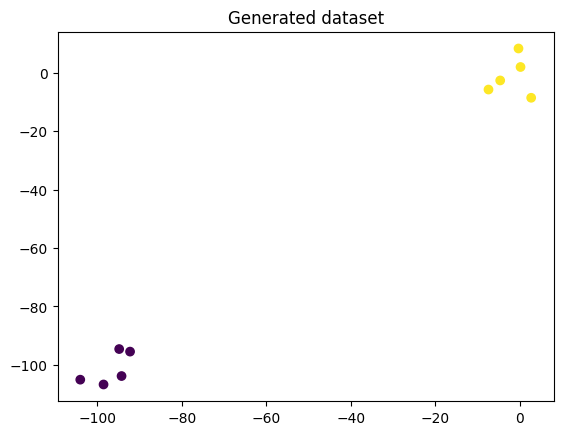

In [7]:
plt.scatter(dataX[:, 0], dataX[:, 1], c=dataLabels)

plt.title("Generated dataset")
plt.show()

In [8]:
hd_params = {"perplexity": n_samples}
D, V = hd_matrix(X=dataX, D=None, V=None,
                    knn_method="sklearn", metric="euclidean", n_neighbors=n_samples, knn_params=None,
                    hd_method="vdm2008", hd_params=hd_params, verbose=1)

Computing the kNN D matrix with k=9 nearest neighbors...
Using sklearn NearestNeighbor, an exact method, for the knn computation
Indexed 10 samples in 0.000s...
Computed neighbors for 10 samples in {duration:.3f}s...
`hd_method` set to `vdm2008`, running with perplexity 5. Returns (D, V)
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 77.878960


# Initialization

In [9]:
data_home = "datasets"
log_path = "temp/poincare/"  # path for saving embedding snapshots
grad_path = "temp/grad/"     # NOTE: We will manually calculate the gradients

seed = 42

dataset = Datasets.MNIST
num_points = [-1]
perplexities = [50]
correct_gradient = True                          # NOTE: Recompile with correct flag (GRAD_FIX flag)
exact = True                                     # Exact computation or BH estimation of gradient
pca_components = 0                               # Whether to use pca initialization of high dim. data or not
grad_scale_fix = True                            # Whether we multiply the gradient by the inverse metric tensor of hyperbolic space or not
                                                 # Note that the correct hyperoblic gradient has an inverse metric tensor factor

# Simple experiment with no exaggeration
exaggeration_factor = 12
ex_iterations = 0
main_iterations = 1000

# Run embedding
Code below runs the embedding procedure for our specified dataset

We compute embeddings for the correct gradient version, and then manually compute the wrong gradient using the embeddings produced by the correct gradient

In [10]:
# Compute initial embedding in Poincare disk (PCA embedding)
cf = HyperbolicKL
X_embedded = initialization(
    n_samples=dataX.shape[0], 
    n_components=2,
    X=dataX,
    random_state=seed,
    method="random"
) 

# Initialize config and parameters
learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)

opt_conf = opt_config(cf, learning_rate, exaggeration_factor, ex_iterations, main_iterations, exact=exact, grad_scale_fix=True, grad_fix=correct_gradient)
opt_params = SequentialOptimizer.sequence_poincare(**opt_conf) 

log_path_cf = log_path + f"cf_{cf.class_str()}/correct_grad_{correct_gradient}/"
grad_path_grad = grad_path + f"cf_{cf.class_str()}/correct_grad_{correct_gradient}/"

opt_params, opt_conf = initialize_logger(opt_params, opt_conf, log_path_cf, grad_path_grad)
opt_params["cf_params"].update({"grad_fix" : correct_gradient})     # So the cost function knows which gradient to use

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
config: {'cf': <class 'hyperbolicTSNE.cost_functions_.HyperbolicKL'>, 'learning_rate_ex': 0.0008333333333333334, 'learning_rate_main': 0.0008333333333333334, 'exaggeration': 12, 'exaggeration_its': 0, 'gradientDescent_its': 1000, 'vanilla': False, 'momentum_ex': 0.5, 'momentum': 0.8, 'exact': True, 'area_split': False, 'n_iter_check': 10, 'size_tol': 0.999, 'grad_scale_fix': True, 'grad_fix': True}


In [11]:
# Set up H-TSNE object 
htsne = HyperbolicTSNE(
    init=X_embedded, 
    n_components=2, 
    metric="precomputed",
    verbose=1, 
    opt_method=SequentialOptimizer,         # the optimizater we use
    opt_params=opt_params              # the parameters for the optimizers
    )

# Compute embedding:
try:
    hyperbolicEmbedding = htsne.fit_transform((D, V))
    
except ValueError:
    hyperbolicEmbedding = find_last_embedding(log_path)
    traceback.print_exc()

[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
Running Gradient Descent, Verbosity: 1
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent: 0it [00:00, ?it/s]


Running Gradient Descent, Verbosity: 1
[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent error: 0.00085 grad_norm: 3.27645e-04: 100%|██████████| 1000/1000 [00:04<00:00, 229.31it/s]


Animation being saved to: results/gradient_vis_images/gradienttesting_cf_HyperbolicKL_correctgrad_True.gif


Animating:   0%|          | 0/200 [00:00<?, ?it/s]f:\School\TU_DELFT_THESIS\hyperbolic-tsne\hyperbolicTSNE\visualization.py:322: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=200.
  anim = FuncAnimation(fig, update, frames=len(scatter_data), interval=50, blit=True, save_count=50)
MovieWriter ffmpeg unavailable; using Pillow instead.
Animating: : 203it [00:14, 14.18it/s]                       


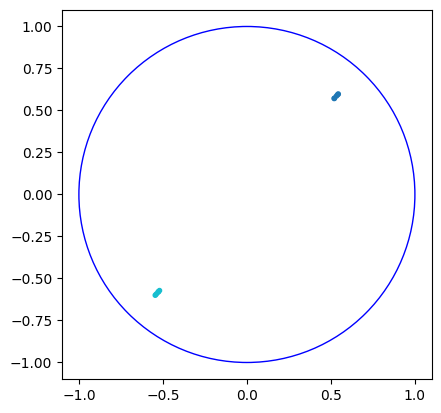

In [12]:
 # Store visuals
save_folder = "results/gradient_vis_images"
file_name = f"{save_folder}/gradienttesting_cf_{cf.class_str()}_correctgrad_{correct_gradient}"

# Create folder if it doesn't exist
path = Path(save_folder)
path.mkdir(parents=True, exist_ok=True)

fig = plot_poincare(hyperbolicEmbedding, dataLabels)
fig.savefig(f"{file_name}.png")

# Save animation
animate(opt_params["logging_dict"], dataLabels, f"{file_name}.gif", fast=True, plot_ee=True)

# Gradient computation


First we compute the gradients for the GaussianKL results

In [16]:
from gradient_experiments import GradientComparisons
from pathlib import Path

embedding_folder_path = f"temp/poincare/cf_{cf.class_str()}/correct_grad_True"              # Where our embeddings are 
output_folder_path = f"results/gradient_comparisons/cf_{cf.class_str()}"                    # Where to store our results
V = V                                                                                       # High dim. affinity matrix, precomputed

# For each type of gradient, calculate the gradients and store the results
for correct_gradient in [True, False]:
    # Initialize config and parameters
    learning_rate = (dataX.shape[0] * 1) / (exaggeration_factor * 1000)

    opt_conf = opt_config(cf, learning_rate, exaggeration_factor, ex_iterations, main_iterations, exact=exact, grad_scale_fix=True, grad_fix=correct_gradient)
    opt_params = SequentialOptimizer.sequence_poincare(**opt_conf) 
    opt_params["cf_params"].update({"grad_fix" : correct_gradient})         # So the cost function knows which gradient to use
    params = opt_params["cf_config_params"] | opt_params["cf_params"]       # Params to initialize cf

    key = f"linear_hierarchical_data_nclusters:{n_clusters}_ndata:{n_samples}"
    cf = HyperbolicKL(n_components=2, other_params=params)                  
    
    # Run experiment
    Experiment_Gradients = GradientComparisons(embedding_folder_path, cf, key)  
    Experiment_Gradients.compute_gradients(V, correct_gradient, output_folder_path)

Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
